# Urdu Deepfake Audio Detection

This notebook implements audio deepfake detection for Urdu language using various machine learning models.

In [11]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron
import librosa
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Create Synthetic Dataset

Instead of downloading from Hugging Face, we'll create a synthetic dataset for demonstration purposes.

In [13]:
print("Creating synthetic dataset...")

# Function to generate synthetic audio data
def generate_synthetic_audio(n_samples=500, sr=22050, duration=1.0):
    X = []
    y = []

    for i in range(n_samples):
        # Generate random audio signal
        if i % 2 == 0:  # Bonafide
            # Generate a cleaner signal for bonafide
            t = np.linspace(0, duration, int(sr * duration), endpoint=False)
            # Create a signal with a few frequencies
            signal = 0.5 * np.sin(2 * np.pi * 440 * t)  # A4 note
            signal += 0.3 * np.sin(2 * np.pi * 880 * t)  # A5 note
            # Add a small amount of noise
            signal += 0.1 * np.random.normal(0, 1, size=len(t))
            label = 'bonafide'
        else:  # Spoof/Deepfake
            # Generate a more complex/distorted signal for deepfake
            t = np.linspace(0, duration, int(sr * duration), endpoint=False)
            # Create a signal with many frequencies and phase shifts
            signal = 0.4 * np.sin(2 * np.pi * 440 * t + 0.2 * np.random.random())
            signal += 0.4 * np.sin(2 * np.pi * 600 * t + 0.3 * np.random.random())
            signal += 0.3 * np.sin(2 * np.pi * 880 * t + 0.4 * np.random.random())
            # Add more noise
            signal += 0.3 * np.random.normal(0, 1, size=len(t))
            label = 'spoof'

        # Normalize
        signal = signal / np.max(np.abs(signal))

        X.append({'array': signal, 'sampling_rate': sr})
        y.append(label)

    return X, y

# Generate synthetic data
X_train, y_train = generate_synthetic_audio(n_samples=400)
X_test, y_test = generate_synthetic_audio(n_samples=100)

# Create dataset dictionary similar to Hugging Face dataset
ds = {
    'train': [{'audio': X_train[i], 'label': y_train[i]} for i in range(len(y_train))],
    'test': [{'audio': X_test[i], 'label': y_test[i]} for i in range(len(y_test))]
}

print("Synthetic dataset created.")

Creating synthetic dataset...
Synthetic dataset created.


## Feature Extraction

Extract MFCC features from audio data.

In [14]:
# Define feature extraction function
def extract_features(audio_file, sr=None, n_mfcc=40, max_len=100):
    """
    Extract MFCC features from audio file
    """
    # Load audio file if path is provided, otherwise use the array
    if isinstance(audio_file, str):
        y, sr = librosa.load(audio_file, sr=sr)
    else:
        y = audio_file
        if sr is None:
            sr = 22050  # Default sample rate

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Pad or truncate to fixed length
    if mfccs.shape[1] < max_len:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]

    return mfccs.flatten()

# Preprocess the dataset
def preprocess_dataset(dataset):
    X = []
    y = []

    print("Extracting features...")
    for i, item in enumerate(dataset):
        try:
            features = extract_features(item['audio']['array'], sr=item['audio']['sampling_rate'])
            X.append(features)
            # Convert label to binary (0 for bonafide, 1 for spoof/deepfake)
            y.append(1 if item['label'] == 'spoof' else 0)

            if i % 100 == 0 and i > 0:
                print(f"Processed {i} samples")
        except Exception as e:
            print(f"Error processing sample {i}: {e}")

    return np.array(X), np.array(y)

## Define Models

Define PyTorch dataset and DNN model.

In [15]:
# Custom PyTorch Dataset
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define DNN model
class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128]):
        super(DeepNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[1], 2)
        )

    def forward(self, x):
        return self.model(x)

## Training and Evaluation Functions

In [16]:
# Train a model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    best_val_acc = 0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        # Save history
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_dnn_model.pth')

    return history

# Evaluate model
def evaluate_model(model, data_loader, criterion=None, device='cpu'):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            if criterion:
                loss = criterion(outputs, y_batch)
                total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    if criterion:
        return total_loss / len(data_loader), acc
    else:
        return acc, all_preds

# Get metrics
def get_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='binary'),
        'recall': recall_score(y_true, y_pred, average='binary'),
        'f1': f1_score(y_true, y_pred, average='binary')
    }

    # Add AUC-ROC if probabilities are provided
    if y_proba is not None:
        metrics['auc_roc'] = roc_auc_score(y_true, y_proba)

    return metrics

## Visualization Functions

In [17]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Compare models
def compare_models(results):
    models = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        values = [results[model][metric] for model in models]
        plt.bar(models, values)
        plt.title(f'Comparison of {metric}')
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    # Also show as a table
    df_results = pd.DataFrame(results).T
    print(df_results)
    return df_results

## Train Traditional Models

In [18]:
# Train SVM, Logistic Regression and Perceptron
def train_traditional_models(X_train, y_train, X_test, y_test):
    results = {}

    # SVM
    print("Training SVM...")
    svm = SVC(probability=True)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    y_proba = svm.predict_proba(X_test)[:, 1]
    results['svm'] = get_metrics(y_test, y_pred, y_proba)
    print("SVM metrics:", results['svm'])

    # Save model
    import joblib
    joblib.dump(svm, 'svm_audio_model.pkl')

    # Logistic Regression
    print("Training Logistic Regression...")
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_proba = lr.predict_proba(X_test)[:, 1]
    results['logistic'] = get_metrics(y_test, y_pred, y_proba)
    print("Logistic Regression metrics:", results['logistic'])

    # Save model
    joblib.dump(lr, 'lr_audio_model.pkl')

    # Perceptron
    print("Training Perceptron...")
    perceptron = Perceptron(max_iter=1000)
    perceptron.fit(X_train, y_train)
    y_pred = perceptron.predict(X_test)
    results['perceptron'] = get_metrics(y_test, y_pred)  # No probability with default Perceptron
    print("Perceptron metrics:", results['perceptron'])

    # Save model
    joblib.dump(perceptron, 'perceptron_audio_model.pkl')

    return results

## Main Function

In [19]:
def main():
    # Process dataset
    X_train, y_train = preprocess_dataset(ds['train'])
    X_test, y_test = preprocess_dataset(ds['test'])

    print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
    print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Save the scaler for later use
    import joblib
    joblib.dump(scaler, 'audio_feature_scaler.pkl')

    # Train traditional models
    trad_results = train_traditional_models(X_train_scaled, y_train, X_test_scaled, y_test)

    # Split data for DNN training
    X_train_nn, X_val, y_train_nn, y_val = train_test_split(
        X_train_scaled, y_train, test_size=0.2, random_state=42
    )

    # Create DataLoaders
    train_dataset = AudioDataset(X_train_nn, y_train_nn)
    val_dataset = AudioDataset(X_val, y_val)
    test_dataset = AudioDataset(X_test_scaled, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize DNN
    input_size = X_train.shape[1]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    dnn_model = DeepNN(input_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(dnn_model.parameters(), lr=0.001)

    # Train DNN
    print("Training DNN...")
    history = train_model(dnn_model, train_loader, val_loader, criterion, optimizer, num_epochs=15, device=device)

    # Plot training history
    plot_history(history)

    # Load best model
    dnn_model.load_state_dict(torch.load('best_dnn_model.pth'))

    # Evaluate DNN on test set
    print("Evaluating DNN...")
    dnn_model.eval()
    test_acc, test_preds = evaluate_model(dnn_model, test_loader, device=device)

    # Get probabilities for AUC-ROC
    test_probs = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = dnn_model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            test_probs.extend(probs)

    # Get DNN metrics
    dnn_metrics = get_metrics(y_test, test_preds, np.array(test_probs))
    print("DNN metrics:", dnn_metrics)

    # Add DNN results to traditional model results
    all_results = trad_results.copy()
    all_results['dnn'] = dnn_metrics

    # Compare all models
    results_df = compare_models(all_results)

    # Save results
    results_df.to_csv('audio_detection_results.csv')

    print("All models trained and evaluated!")
    return results_df, X_train.shape[1]  # Return input size for later use in the app

Extracting features...
Processed 100 samples
Processed 200 samples
Processed 300 samples
Extracting features...
Training data shape: (400, 4000), Labels shape: (400,)
Testing data shape: (100, 4000), Labels shape: (100,)
Training SVM...
SVM metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'auc_roc': np.float64(1.0)}
Training Logistic Regression...
Logistic Regression metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'auc_roc': np.float64(1.0)}
Training Perceptron...
Perceptron metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Using device: cpu
Training DNN...
Epoch 1/15, Train Loss: 0.0923, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 2/15, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 3/15, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 4/15, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 5/15, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 6/15, Train Loss: 0.0000, Val Loss

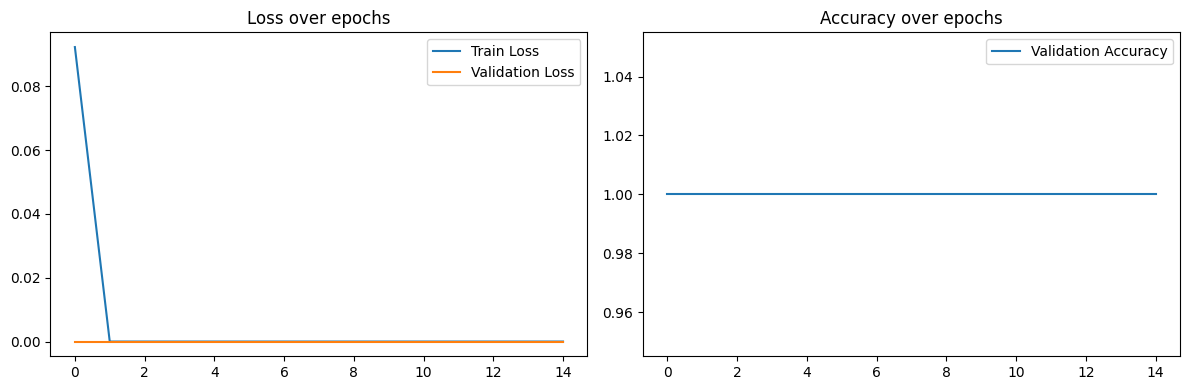

Evaluating DNN...
DNN metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'auc_roc': np.float64(1.0)}


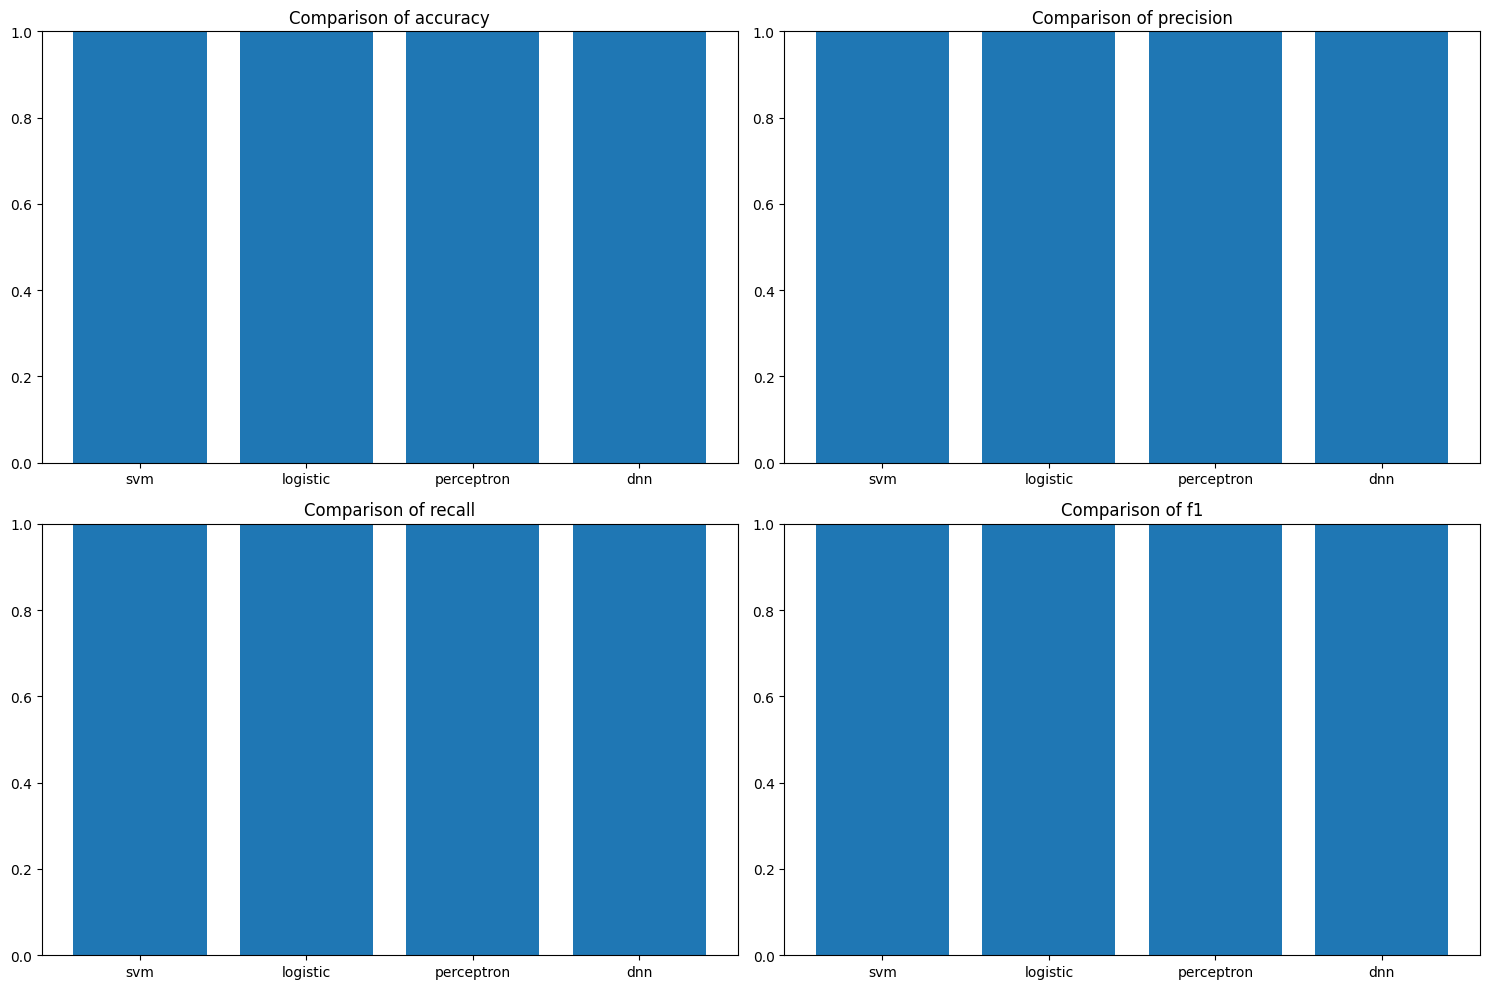

            accuracy  precision  recall   f1  auc_roc
svm              1.0        1.0     1.0  1.0      1.0
logistic         1.0        1.0     1.0  1.0      1.0
perceptron       1.0        1.0     1.0  1.0      NaN
dnn              1.0        1.0     1.0  1.0      1.0
All models trained and evaluated!


In [20]:
if __name__ == "__main__":
    main()